# Dealing with imbalanced data by model weighting

A problem with machine learning models is that they may end up biased towards the majority class, and under-predict the minority class(es).

Some models (including sklearn's logistic regression) allow for classes to be weighted differently, which penalises the model more when those classes are incorrectly predicted.

Here we create a more imbalanced data set from the Titanic set, by dropping half the survivors.

We create a list of alternative weight balance between the two classes ('died' and 'survived') and the effect of class weights on a range of accuracy measures.

Note: You will need to look at the help files and documentation of other model types to find whether they have options ro change class weights. If a model type does not allow for changing weight classes then other techniques like changing classification thresholds, under-sampling, over-sampling, or SMOTE should be considered (described in other notebooks). 

In [1]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [2]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Artificially reduce the number of survivors (to make data set more imbalanced)

In [6]:
# Shuffle original data
data = data.sample(frac=1.0) # Sampling with a fraction of 1.0 shuffles data

# Create masks for filters
mask_died = data['Survived'] == 0
mask_survived = data['Survived'] == 1

# Filter data
died = data[mask_died]
survived = data[mask_survived]

# Reduce survived by half
survived = survived.sample(frac=0.5)

# Recombine data and shuffle
data = pd.concat([died, survived])
data = data.sample(frac=1.0) 

# Show average of survived
survival_rate = data['Survived'].mean()
print ('Proportion survived:', np.round(survival_rate,3))

Proportion survived: 0.238


## Define function to standardise data

In [7]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Define function to measure accuracy

The following is a function for multiple accuracy measures.

In [8]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [9]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Assess accuracy, precision, recall and f1 at different model weights

### Create a range of weights to use

Logistic regression models take weights as a dictionary in the form `{label_1:weight, label_2:weight, etc}`. Below we will create a list of alternative weighting schemes.

In [10]:
weights = []
for weight in np.arange(0.02,0.99,0.02):
    weight_item = {0:weight, 1:1-weight}
    weights.append(weight_item)

## Run our model with different weights

We will use stratified k-fold verification to assess the model performance. If you are not familiar with this please see:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

In [11]:
# Create NumPy arrays of X and y (required for k-fold)
X_np = X.values
y_np = y.values

# Create lists for overall results

results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_predicted_positive_rate = []

# Loop through list of model weights

for weight in weights:
    
    # Create lists for k-fold results
    kfold_accuracy = []
    kfold_precision = []
    kfold_recall = []
    kfold_f1 = []
    kfold_predicted_positive_rate = []
    
    # Set up k-fold training/test splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y_np)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):

        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Set up and fit model
        model = LogisticRegression(solver='lbfgs', class_weight=weight)
        model.fit(X_train_std,y_train)
        
        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        kfold_accuracy.append(accuracy_scores['accuracy'])
        kfold_precision.append(accuracy_scores['precision'])
        kfold_recall.append(accuracy_scores['recall'])
        kfold_f1.append(accuracy_scores['f1'])
        kfold_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])
                        
    # Add mean results to overall results
    results_accuracy.append(np.mean(kfold_accuracy))
    results_precision.append(np.mean(kfold_precision))
    results_recall.append(np.mean(kfold_recall))
    results_f1.append(np.mean(kfold_f1))
    results_predicted_positive_rate.append(
        np.mean(kfold_predicted_positive_rate))

# Transfer results to dataframe
results = pd.DataFrame(weights)
results['accuracy'] = results_accuracy
results['precision'] = results_precision
results['recall'] = results_recall
results['f1'] = results_f1
results['predicted_positive_rate'] = results_predicted_positive_rate

### Plot results

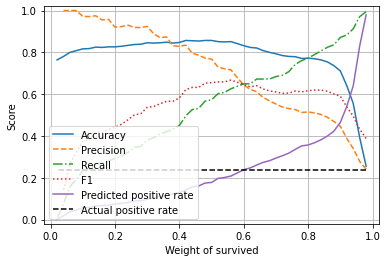

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = results[1]

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')


plt.xlabel('Weight of survived')
plt.ylabel('Score')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

## Observations

* Accuracy is maximised when classes are equally weighted.
* When weights are equal the minority class ('survived') is under-predicted.
* A weight of 0.6 for survived (c.f. 0.4 for non-survived) balances precision and recall and correctly estimates the proportion of passengers who survive.
* There is a marginal reduction in overall accuracy in order to balance accuracy of the classes.